In [3]:
#!/usr/bin/env python3
"""
improved_lbp_glcm_pipeline.py

- ROI extraction (consistent normal/abnormal)
- per-ROI CLAHE
- LBP pooled features (adaptive bins)
- quantized GLCM features
- SelectKBest feature selection inside pipeline
- SMOTE inside CV if available, else class_weight fallback
- nested GroupKFold (inner) GridSearchCV and held-out GroupShuffleSplit
- prints and saves results to ./results/
"""
import os
import math
import pickle
import numpy as np
import pandas as pd
import cv2
from collections import Counter
import matplotlib.pyplot as plt

from skimage.feature import local_binary_pattern, graycomatrix, graycoprops

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, GroupShuffleSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.pipeline import Pipeline

# try to import imblearn (SMOTE & pipeline). If missing fallback will be used.
USE_SMOTE = True
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline as ImbPipeline
except Exception:
    USE_SMOTE = False
    ImbPipeline = None
    print("[WARN] imbalanced-learn not available. Script will use class_weight='balanced' instead of SMOTE.")

# ----------------- USER CONFIG -----------------
IMAGES_DIR = "all-mias"
META_PATH = "data2.txt"
IMAGE_SIZE = 1024               # MIAS image size reference
TARGET_SIZE = 128               # None to keep native crop size, or int to resize (128 recommended)
MIN_SIDE = 32                   # pad if ROI smaller
CLAHE_CLIP = 2.0
CLAHE_TILE = (8, 8)

# LBP params
P = 8
# You can enable multi-scale LBP; set RB list to include desired radii:
LBP_RADII = [1, 3]             # set to [3] or [1,3] for multiscale
LBP_METHOD = 'uniform'

# pooling grid for LBP
POOL_G = 3                      # 3x3 pooling (try 3,4,6). smaller reduces dims

# GLCM params (quantized)
GLCM_LEVELS = 32
GLCM_DISTANCES = [1, 3]
GLCM_ANGLES = [0, np.pi/4, np.pi/2, 3*np.pi/4]

# CV params
OUTER_SPLITS = 5
INNER_SPLITS = 4
RANDOM_STATE = 42
HOLDOUT_TEST_SIZE = 0.2

# Grid search params
RF_PARAM_GRID = {
    'clf__n_estimators': [100, 300],
    'clf__max_depth': [6, 12, None],
    'clf__min_samples_leaf': [2, 6],
}
SVM_PARAM_GRID = {
    'clf__C': [0.1, 1, 10],
    'clf__gamma': ['scale', 0.01],
}

SELECT_K = 80  # number of features to keep with SelectKBest (set based on experiments)

# ------------------------------------------------

# ---------- helper functions ----------
def read_metadata(meta_path):
    col_names = ['REFNUM', 'BG', 'CLASS', 'SEVERITY', 'X', 'Y', 'RADIUS']
    df = pd.read_csv(meta_path, sep=r"\s+", names=col_names, header=None)
    df['CANCER'] = df['SEVERITY'].apply(lambda x: 1 if x in ['B', 'M'] else 0)
    return df

def ref_to_patient_id(ref):
    try:
        n = int(''.join(ch for ch in ref if ch.isdigit()))
        return (n - 1) // 2
    except:
        return ref

def clamp(a, lo, hi):
    return max(lo, min(hi, a))

def crop_square(img, cx, cy, r):
    H, W = img.shape
    x0 = clamp(cx - r, 0, W)
    x1 = clamp(cx + r, 0, W)
    y0 = clamp(cy - r, 0, H)
    y1 = clamp(cy + r, 0, H)
    if x1 <= x0 or y1 <= y0:
        return img.copy()
    return img[y0:y1, x0:x1]

def pad_to_min_side(img, min_side):
    h, w = img.shape
    top = bottom = left = right = 0
    if h < min_side:
        extra = min_side - h
        top = extra // 2
        bottom = extra - top
    if w < min_side:
        extra = min_side - w
        left = extra // 2
        right = extra - left
    if any([top, bottom, left, right]):
        img = cv2.copyMakeBorder(img, top, bottom, left, right, borderType=cv2.BORDER_REFLECT)
    return img

def apply_clahe_to_roi(roi, clip=2.0, tile=(8,8)):
    if roi.dtype != np.uint8:
        if roi.max() <= 1.0:
            roi_u8 = (roi * 255).astype(np.uint8)
        else:
            roi_u8 = roi.astype(np.uint8)
    else:
        roi_u8 = roi
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=tile)
    return clahe.apply(roi_u8)

def pooled_lbp_matrix(lbp_map, G=3, n_bins=None):
    H, W = lbp_map.shape
    row_edges = np.linspace(0, H, G+1, dtype=int)
    col_edges = np.linspace(0, W, G+1, dtype=int)
    rows = []
    # use dynamic n_bins from caller
    for i in range(G):
        for j in range(G):
            r0, r1 = row_edges[i], row_edges[i+1]
            c0, c1 = col_edges[j], col_edges[j+1]
            region = lbp_map[r0:r1, c0:c1]
            # ensure integer codes
            region_int = region.ravel().astype(int)
            if n_bins is None:
                n_bins_reg = int(region_int.max()) + 1 if region_int.size>0 else 1
                hist = np.bincount(region_int, minlength=n_bins_reg).astype(float)
            else:
                hist = np.bincount(region_int, minlength=n_bins).astype(float)
            if hist.sum() > 0:
                hist /= hist.sum()
            # if n_bins is provided, hist length is fixed
            if n_bins is not None and len(hist) < n_bins:
                # pad
                hist = np.pad(hist, (0, n_bins - len(hist)), mode='constant')
            rows.append(hist)
    M = np.vstack(rows)
    return M

def quantize_img_levels(img, levels=32):
    a = img.astype(np.float32)
    if a.max() > 1.1:
        a = a / 255.0
    q = np.floor(a * (levels - 1) + 0.5).astype(np.uint8)
    return q

def extract_glcm_features(patch, distances, angles, levels):
    q = quantize_img_levels(patch, levels=levels)
    glcm = graycomatrix(q, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)
    props = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']
    feats = []
    for p in props:
        mat = graycoprops(glcm, p)
        feats.append(float(np.nanmean(mat)))
        feats.append(float(np.nanvar(mat)))
    return np.array(feats, dtype=float)  # length = 2 * len(props)

# ---------- main ----------
def main():
    print("[INFO] Reading metadata...")
    df = read_metadata(META_PATH)
    refs = sorted([f for f in os.listdir(IMAGES_DIR) if f.lower().endswith('.pgm')])
    print(f"[INFO] Found {len(refs)} image files in {IMAGES_DIR}")
    radii = pd.to_numeric(df['RADIUS'], errors='coerce').dropna()
    median_radius = int(radii.median()) if radii.size > 0 else 48
    print("[INFO] median radius:", median_radius)

    # ROI extraction
    rois = []
    rois_raw = []   # keep a raw copy (pre-CLAHE) for comparisons
    labels = []
    groups = []
    ref_list = []

    for fname in refs:
        ref = os.path.splitext(fname)[0]
        row = df[df['REFNUM'] == ref]
        if row.empty:
            continue
        row = row.iloc[0]
        img_path = os.path.join(IMAGES_DIR, fname)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print("[WARN] cannot read", img_path); continue

        label = int(row['CANCER'])
        x, y, r = row['X'], row['Y'], row['RADIUS']

        if label == 1 and pd.notna(x) and pd.notna(y) and pd.notna(r):
            cx = int(float(x))
            cy = int(IMAGE_SIZE - float(y))  # convert bottom-left MIAS to top-left indexing
            rr = int(max(int(r), 8))
            roi = crop_square(img, cx, cy, rr)
        else:
            cx = img.shape[1] // 2
            cy = img.shape[0] // 2
            rr = median_radius
            roi = crop_square(img, cx, cy, rr)

        roi = pad_to_min_side(roi, MIN_SIDE)
        rois_raw.append(roi.copy())
        roi_clahe = apply_clahe_to_roi(roi, clip=CLAHE_CLIP, tile=CLAHE_TILE)
        if TARGET_SIZE is not None:
            if roi_clahe.shape[0] > TARGET_SIZE or roi_clahe.shape[1] > TARGET_SIZE:
                interp = cv2.INTER_AREA
            else:
                interp = cv2.INTER_LINEAR
            roi_clahe = cv2.resize(roi_clahe, (TARGET_SIZE, TARGET_SIZE), interpolation=interp)

        rois.append(roi_clahe)
        labels.append(label)
        groups.append(ref_to_patient_id(ref))
        ref_list.append(ref)

    print(f"[INFO] Extracted {len(rois)} ROIs (CLAHE applied per-ROI).")
    if len(rois) == 0:
        raise RuntimeError("No ROIs extracted - check dataset paths and metadata.")

    # Compute LBP maps for each radius and collect global max code to set fixed bins
    print("[INFO] Computing LBP maps for radii:", LBP_RADII)
    lbp_maps_per_radius = {r: [] for r in LBP_RADII}
    max_code = 0
    for roi in rois:
        # ensure float input
        img_float = roi.astype(np.float32)
        for r in LBP_RADII:
            lbp_map = local_binary_pattern(img_float, P, r, method=LBP_METHOD)
            # LBP returns floats; convert to ints safely
            lbp_int = np.round(lbp_map).astype(int)
            lbp_maps_per_radius[r].append(lbp_int)
            max_code = max(max_code, int(lbp_int.max()))

    n_lbp_bins = max_code + 1
    print(f"[INFO] Determined LBP n_bins = {n_lbp_bins}")

    # Build feature matrices
    X_lbp_parts = []  # will contain per-radius pooled LBP flattened
    X_glcm = []
    print("[INFO] Building pooled LBP histograms and GLCM features for each ROI...")
    for idx, roi in enumerate(rois):
        roi_uint8 = roi.astype(np.uint8)
        # LBP pooled for each radius, concatenate
        lbp_concat = []
        for r in LBP_RADII:
            lbp_map = lbp_maps_per_radius[r][idx]
            M = pooled_lbp_matrix(lbp_map, G=POOL_G, n_bins=n_lbp_bins)  # shape (G*G, n_bins)
            lbp_concat.append(M.ravel())
        lbp_vec = np.hstack(lbp_concat)
        X_lbp_parts.append(lbp_vec)

        # GLCM features (quantized)
        glcm_feats = extract_glcm_features(roi_uint8, distances=GLCM_DISTANCES, angles=GLCM_ANGLES, levels=GLCM_LEVELS)
        X_glcm.append(glcm_feats)

    X_lbp = np.vstack(X_lbp_parts)
    X_glcm = np.vstack(X_glcm)
    X = np.hstack([X_glcm, X_lbp])
    y = np.array(labels)
    groups_arr = np.array(groups)

    print("[INFO] Feature shapes: X_glcm", X_glcm.shape, "X_lbp", X_lbp.shape, "combined X", X.shape)
    print("Label counts:", Counter(y))
    # safety check
    if np.isnan(X).any():
        raise RuntimeError("NaN found in features!")

    # Create feature names for mapping importances
    glcm_props = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']
    glcm_names = []
    for p in glcm_props:
        glcm_names += [f"{p}_mean", f"{p}_var"]
    lbp_names = []
    region_count = POOL_G * POOL_G
    for r in LBP_RADII:
        for region_ix in range(region_count):
            for code in range(n_lbp_bins):
                lbp_names.append(f"LBP_R{r}_r{region_ix:02d}_c{code:03d}")
    feature_names = glcm_names + lbp_names
    assert X.shape[1] == len(feature_names)

    # ---------------- train/test split (group-aware held-out) ----------------
    gss = GroupShuffleSplit(n_splits=1, test_size=HOLDOUT_TEST_SIZE, random_state=RANDOM_STATE)
    train_idx, test_idx = next(gss.split(X, y, groups_arr))
    X_tr, X_te = X[train_idx], X[test_idx]
    y_tr, y_te = y[train_idx], y[test_idx]
    groups_tr, groups_te = groups_arr[train_idx], groups_arr[test_idx]
    print("[INFO] Train samples:", X_tr.shape[0], "Test samples:", X_te.shape[0])

    # Build pipelines: keep feature selection inside pipeline (SelectKBest)
    selector = SelectKBest(mutual_info_classif, k=min(SELECT_K, X_tr.shape[1]))

    # If SMOTE available, put inside ImbPipeline, else use sklearn Pipeline and class_weight
    if USE_SMOTE:
        rf_pipeline = ImbPipeline([
            ('smote', SMOTE(random_state=RANDOM_STATE)),
            ('scaler', StandardScaler()),
            ('select', selector),
            ('clf', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced', n_jobs=-1))
        ])
        svm_pipeline = ImbPipeline([
            ('smote', SMOTE(random_state=RANDOM_STATE)),
            ('scaler', StandardScaler()),
            ('select', selector),
            ('clf', SVC(probability=True, class_weight='balanced', random_state=RANDOM_STATE))
        ])
    else:
        rf_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('select', selector),
            ('clf', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced', n_jobs=-1))
        ])
        svm_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('select', selector),
            ('clf', SVC(probability=True, class_weight='balanced', random_state=RANDOM_STATE))
        ])

    # inner CV uses GroupKFold on training set
    def run_gridsearch(pipeline, param_grid, X_train, y_train, groups_train, name="model"):
        inner_cv = GroupKFold(n_splits=INNER_SPLITS)
        gs = GridSearchCV(pipeline, param_grid, cv=inner_cv.split(X_train, y_train, groups_train),
                          scoring='roc_auc', n_jobs=-1, verbose=1)
        gs.fit(X_train, y_train)
        print(f"[INFO] Best {name} params:", gs.best_params_)
        return gs.best_estimator_, gs

    print("[INFO] Running inner grid-search for RandomForest...")
    best_rf, rf_gs = run_gridsearch(rf_pipeline, RF_PARAM_GRID, X_tr, y_tr, groups_tr, name="RandomForest")

    print("[INFO] Running inner grid-search for SVM...")
    best_svm, svm_gs = run_gridsearch(svm_pipeline, SVM_PARAM_GRID, X_tr, y_tr, groups_tr, name="SVM")

    # Evaluate on held-out test set
    def evaluate_model(est, X_test, y_test, name="model"):
        y_pred = est.predict(X_test)
        if hasattr(est, "predict_proba"):
            try:
                y_prob = est.predict_proba(X_test)[:, 1]
            except Exception:
                y_prob = None
        else:
            y_prob = None
        print(f"\n=== Held-out evaluation: {name} ===")
        print("Accuracy:", accuracy_score(y_test, y_pred))
        print("Recall:", recall_score(y_test, y_pred, zero_division=0))
        if y_prob is not None and len(np.unique(y_test)) > 1:
            print("AUC:", roc_auc_score(y_test, y_prob))
        print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
        print(classification_report(y_test, y_pred))
        return y_pred, y_prob

    ypred_rf, yprob_rf = evaluate_model(best_rf, X_te, y_te, name="RandomForest (best)")
    ypred_svm, yprob_svm = evaluate_model(best_svm, X_te, y_te, name="SVM (best)")

    # Feature importances mapping (RF)
    try:
        rf_clf = best_rf.named_steps['clf'] if USE_SMOTE else best_rf.named_steps['clf']
        importances = rf_clf.feature_importances_
        # map to names
        idxs = np.argsort(importances)[::-1][:30]
        print("\nTop 30 feature importances (index, name, importance):")
        for idx in idxs:
            print(idx, feature_names[idx], f"{importances[idx]:.4f}")
    except Exception as e:
        print("[WARN] Could not extract feature importances:", e)

    # Threshold tuning on held-out set to prioritize recall if desired (example)
    if yprob_rf is not None:
        best_thresh = 0.5
        best_recall = recall_score(y_te, (yprob_rf >= 0.5).astype(int))
        # choose threshold that maximizes recall while keeping precision >= 0.5 (example)
        for t in np.linspace(0.1, 0.9, 81):
            preds_t = (yprob_rf >= t).astype(int)
            r = recall_score(y_te, preds_t, zero_division=0)
            # for illustration choose threshold maximizing recall
            if r > best_recall:
                best_recall = r; best_thresh = t
        print(f"[INFO] RF held-out best threshold for recall (example): {best_thresh:.2f}, recall={best_recall:.3f}")
        # show confusion at best threshold
        preds_best = (yprob_rf >= best_thresh).astype(int)
        print("Confusion at chosen threshold:\n", confusion_matrix(y_te, preds_best))
        print(classification_report(y_te, preds_best))

    # Save outputs
    os.makedirs("results", exist_ok=True)
    with open(os.path.join("results", "features_X_y_groups.pkl"), "wb") as f:
        pickle.dump({"X": X, "y": y, "groups": groups_arr, "ref_list": ref_list, "feature_names": feature_names}, f)
    with open(os.path.join("results", "best_rf.pkl"), "wb") as f:
        pickle.dump(best_rf, f)
    with open(os.path.join("results", "best_svm.pkl"), "wb") as f:
        pickle.dump(best_svm, f)

    print("\n[INFO] Done. Results and models saved to ./results/")

if __name__ == "__main__":
    main()


[WARN] imbalanced-learn not available. Script will use class_weight='balanced' instead of SMOTE.
[INFO] Reading metadata...
[INFO] Found 324 image files in all-mias
[INFO] median radius: 43
[INFO] Extracted 324 ROIs (CLAHE applied per-ROI).
[INFO] Computing LBP maps for radii: [1, 3]


c:\python3\Lib\site-packages\skimage\feature\texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


[INFO] Determined LBP n_bins = 10
[INFO] Building pooled LBP histograms and GLCM features for each ROI...
[INFO] Feature shapes: X_glcm (324, 12) X_lbp (324, 180) combined X (324, 192)
Label counts: Counter({np.int64(0): 207, np.int64(1): 117})
[INFO] Train samples: 258 Test samples: 66
[INFO] Running inner grid-search for RandomForest...
Fitting 4 folds for each of 12 candidates, totalling 48 fits
[INFO] Best RandomForest params: {'clf__max_depth': 12, 'clf__min_samples_leaf': 6, 'clf__n_estimators': 300}
[INFO] Running inner grid-search for SVM...
Fitting 4 folds for each of 6 candidates, totalling 24 fits
[INFO] Best SVM params: {'clf__C': 1, 'clf__gamma': 'scale'}

=== Held-out evaluation: RandomForest (best) ===
Accuracy: 0.8333333333333334
Recall: 0.75
AUC: 0.8938492063492064
Confusion Matrix:
 [[37  5]
 [ 6 18]]
              precision    recall  f1-score   support

           0       0.86      0.88      0.87        42
           1       0.78      0.75      0.77        24

    a

In [7]:
# Improved_Method2_fixed.py
import os
import math
import pickle
import numpy as np
import pandas as pd
import cv2
from collections import Counter

from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from sklearn.model_selection import GroupKFold, GroupShuffleSplit, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Optional: imblearn SMOTE
USE_SMOTE = True
try:
    from imblearn.pipeline import Pipeline as ImbPipeline
    from imblearn.over_sampling import SMOTE
except Exception:
    USE_SMOTE = False
    ImbPipeline = None
    SMOTE = None
    print("[WARN] imblearn not available. SMOTE disabled.")

# Optional: SHAP
USE_SHAP = True
try:
    import shap
except Exception:
    USE_SHAP = False
    print("[WARN] shap not available. SHAP plots will be skipped.")

# -------------------------
# Config
# -------------------------
IMAGES_DIR = "all-mias"     # adjust path if needed
META_PATH = "data2.txt"
IMAGE_SIZE = 1024
TARGET_SIZE = 128
RANDOM_STATE = 42

# LBP settings
P = 8
LBP_RADII = [1, 3]          # radii to compute and concatenate
LBP_UNIFORM_BINS = 59      # uniform LBP with P=8 -> 59 bins per radius

# GLCM settings
GLCM_LEVELS = 32
GLCM_DISTANCES = [1, 3]
GLCM_ANGLES = [0, np.pi/4, np.pi/2, 3*np.pi/4]

# Feature selection
SELECT_K = 100   # will be clipped to number of features

# Grid for RF (example)
RF_GRID = {
    'clf__n_estimators': [100, 200],
    'clf__max_depth': [6, 12, None],
    'clf__min_samples_leaf': [1, 3]
}

# -------------------------
# Helpers
# -------------------------
def read_metadata(meta_path):
    col_names = ['REFNUM', 'BG', 'CLASS', 'SEVERITY', 'X', 'Y', 'RADIUS']
    df = pd.read_csv(meta_path, sep=r"\s+", names=col_names, header=None)
    # convert RADIUS to numeric safely
    df['RADIUS'] = pd.to_numeric(df['RADIUS'], errors='coerce')
    df['CANCER'] = df['SEVERITY'].apply(lambda x: 1 if x in ['B','M'] else 0)
    return df

def ref_to_patient_id(ref):
    # extracts digits and map pairs to patient id as (n-1)//2 + 1
    import re
    m = re.search(r"\d+", str(ref))
    if not m:
        return 0
    n = int(m.group(0))
    return ((n - 1) // 2) + 1

def extract_roi(img, rec, median_radius):
    # rec expected to be a pandas Series row
    label = rec['CANCER']
    x, y, r = rec['X'], rec['Y'], rec['RADIUS']
    if label==1 and not pd.isna(x) and not pd.isna(y) and not pd.isna(r):
        cx = int(x)
        cy = int(IMAGE_SIZE - float(y))  # MIAS coordinate conversion
        cr = int(r)
    else:
        cx = IMAGE_SIZE // 2
        cy = IMAGE_SIZE // 2
        cr = int(median_radius)
    x0, y0 = max(0, cx - cr), max(0, cy - cr)
    x1, y1 = min(IMAGE_SIZE, cx + cr), min(IMAGE_SIZE, cy + cr)
    roi = img[y0:y1, x0:x1]
    if roi.size == 0:
        return None
    # CLAHE
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    roi = clahe.apply(roi)
    roi = cv2.resize(roi, (TARGET_SIZE, TARGET_SIZE), interpolation=cv2.INTER_AREA)
    return roi

def extract_lbp_features(patch, P=P, radii=LBP_RADII, n_bins=LBP_UNIFORM_BINS):
    feats = []
    for R in radii:
        lbp = local_binary_pattern(patch, P, R, method='uniform')
        # fixed bins to n_bins (59) to keep stable feature length
        hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)
        feats.extend(hist.astype(float).tolist())
    return feats

def extract_glcm_features(patch, levels=GLCM_LEVELS, distances=GLCM_DISTANCES, angles=GLCM_ANGLES):
    # quantize patch to 'levels'
    patch_q = (patch / (256 / levels)).astype(np.uint8)
    glcm = graycomatrix(patch_q, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)
    props = ['contrast','dissimilarity','homogeneity','ASM','energy','correlation']
    feats = []
    for p in props:
        vals = graycoprops(glcm, p)
        feats.extend(vals.mean(axis=1).tolist())  # mean across angles/distances
    return feats

def extract_intensity_stats(patch):
    return [float(patch.mean()), float(patch.std()), float(patch.min()), float(patch.max())]

# -------------------------
# Build feature matrix
# -------------------------
meta = read_metadata(META_PATH)
median_radius = int(meta.loc[meta['CANCER']==1, 'RADIUS'].dropna().median()) if meta['RADIUS'].notna().any() else 48

features_list = []
labels = []
groups = []
filenames = []

for fname in sorted(os.listdir(IMAGES_DIR)):
    if not fname.lower().endswith('.pgm'):
        continue
    ref = os.path.splitext(fname)[0]
    rec = meta[meta['REFNUM'] == ref]
    if rec.empty:
        continue
    rec = rec.iloc[0]
    img_path = os.path.join(IMAGES_DIR, fname)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue
    roi = extract_roi(img, rec, median_radius)
    if roi is None:
        continue
    lbp_feat = extract_lbp_features(roi)
    glcm_feat = extract_glcm_features(roi)
    int_feat = extract_intensity_stats(roi)
    feat = lbp_feat + glcm_feat + int_feat
    features_list.append(feat)
    labels.append(int(rec['CANCER']))
    gid = ref_to_patient_id(ref)
    groups.append(gid)
    filenames.append(ref)

X = np.array(features_list, dtype=float)
y = np.array(labels, dtype=int)
groups = np.array(groups, dtype=int)

print(f"[INFO] Built features: X.shape={X.shape}, positives={y.sum()}, unique_groups={np.unique(groups).shape[0]}")

# -------------------------
# Pipeline + nested CV
# -------------------------
# make sure SELECT_K not larger than number of features
n_features = X.shape[1]
SELECT_K_SAFE = min(SELECT_K if 'SELECT_K' in globals() else 100, n_features)

selector = SelectKBest(mutual_info_classif, k=SELECT_K_SAFE)
scaler = StandardScaler()
rf = RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE)

steps = [('scaler', scaler), ('select', selector), ('clf', rf)]
if USE_SMOTE and ImbPipeline:
    pipeline = ImbPipeline([('smote', SMOTE(random_state=RANDOM_STATE))] + steps)
else:
    from sklearn.pipeline import Pipeline as SKPipeline
    pipeline = SKPipeline(steps)

cv_outer = GroupKFold(n_splits=5)
cv_inner = GroupKFold(n_splits=4)

search = GridSearchCV(pipeline, RF_GRID, cv=cv_inner, scoring='roc_auc', n_jobs=-1, refit=True, verbose=1)

outer_scores = []
fold_idx = 0
for train_idx, test_idx in cv_outer.split(X, y, groups):
    fold_idx += 1
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    groups_train, groups_test = groups[train_idx], groups[test_idx]

    # Note: pass groups to fit so inner GroupKFold can use them
    print(f"[INFO] Outer fold {fold_idx}: train={X_train.shape[0]} test={X_test.shape[0]} groups_train={np.unique(groups_train).size}")
    search.fit(X_train, y_train, groups=groups_train)

    best = search.best_estimator_
    y_pred = best.predict(X_test)
    y_prob = best.predict_proba(X_test)[:,1] if hasattr(best, "predict_proba") else best.decision_function(X_test)
    acc = accuracy_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if len(np.unique(y_test))>1 else float('nan')
    rec = recall_score(y_test, y_pred, zero_division=0)
    outer_scores.append({'acc': acc, 'auc': auc, 'recall': rec})
    print(f" Fold {fold_idx} -> acc={acc:.3f} auc={auc:.3f} recall={rec:.3f}")

# Summary
import statistics
accs = [s['acc'] for s in outer_scores]
aucs = [s['auc'] for s in outer_scores if not math.isnan(s['auc'])]
recs = [s['recall'] for s in outer_scores]
print("=== Outer CV summary ===")
print(f"Accuracy: {np.mean(accs):.3f} ± {np.std(accs):.3f}")
print(f"AUC:      {np.mean(aucs):.3f} ± {np.std(aucs):.3f}")
print(f"Recall:   {np.mean(recs):.3f} ± {np.std(recs):.3f}")

# Fit final model on full data (pass groups)
search.fit(X, y, groups=groups)
best_final = search.best_estimator_

# Save model
with open("final_rf_model_fixed.pkl", "wb") as f:
    pickle.dump(best_final, f)
print("[INFO] Saved final model to final_rf_model_fixed.pkl")

# Optional SHAP explanations (if available)
if USE_SHAP:
    try:
        # Get feature names
        feat_names = []
        # LBP feature names
        for r in LBP_RADII:
            for i in range(LBP_UNIFORM_BINS):
                feat_names.append(f"lbp_r{r}_{i}")
        # GLCM names
        props = ['contrast','dissimilarity','homogeneity','ASM','energy','correlation']
        for p in props:
            for d in GLCM_DISTANCES:
                feat_names.append(f"glcm_{p}_d{d}")
        feat_names += ['mean_int','std_int','min_int','max_int']
        # prepare transformed data (through scaler+selector pipeline)
        transformed = best_final.named_steps['select'].transform(best_final.named_steps['scaler'].transform(X))
        explainer = shap.KernelExplainer(best_final.named_steps['clf'].predict_proba, transformed[:50])
        shap_vals = explainer.shap_values(transformed[:200])  # small subset
        # Save a simple summary
        shap.summary_plot(shap_vals[1], features=transformed, feature_names=feat_names, show=False)
    except Exception as e:
        print("[WARN] SHAP failed:", e)


[WARN] imblearn not available. SMOTE disabled.
[WARN] shap not available. SHAP plots will be skipped.
[INFO] Built features: X.shape=(324, 134), positives=117, unique_groups=162
[INFO] Outer fold 1: train=258 test=66 groups_train=129
Fitting 4 folds for each of 12 candidates, totalling 48 fits
 Fold 1 -> acc=0.939 auc=0.986 recall=0.870
[INFO] Outer fold 2: train=258 test=66 groups_train=129
Fitting 4 folds for each of 12 candidates, totalling 48 fits
 Fold 2 -> acc=0.879 auc=0.919 recall=0.786
[INFO] Outer fold 3: train=260 test=64 groups_train=130
Fitting 4 folds for each of 12 candidates, totalling 48 fits
 Fold 3 -> acc=0.859 auc=0.924 recall=0.708
[INFO] Outer fold 4: train=260 test=64 groups_train=130
Fitting 4 folds for each of 12 candidates, totalling 48 fits
 Fold 4 -> acc=0.938 auc=0.988 recall=0.895
[INFO] Outer fold 5: train=260 test=64 groups_train=130
Fitting 4 folds for each of 12 candidates, totalling 48 fits
 Fold 5 -> acc=0.891 auc=0.882 recall=0.696
=== Outer CV summ

In [8]:
# run_method2_heldout_summary.py
import os
import math
import pickle
import cv2
import numpy as np
import pandas as pd
from collections import Counter
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, classification_report, confusion_matrix, precision_score, f1_score
from sklearn.pipeline import Pipeline

# Optional: imblearn SMOTE
USE_SMOTE = False
try:
    from imblearn.pipeline import Pipeline as ImbPipeline
    from imblearn.over_sampling import SMOTE
    USE_SMOTE = True
except Exception:
    USE_SMOTE = False

# Optional: SHAP
USE_SHAP = False
try:
    import shap
    USE_SHAP = True
except Exception:
    USE_SHAP = False

# ---------- CONFIG ----------
IMAGES_DIR = "all-mias"   # folder with .pgm files
META_PATH = "data2.txt"
IMAGE_SIZE = 1024
TARGET_SIZE = 128        # change to 64/256 to trade speed vs detail
RANDOM_STATE = 42

# LBP (uniform)
P = 8
LBP_RADII = [1, 3]      # radii to use
LBP_BINS = 59           # fixed for uniform P=8

# GLCM (simple)
GLCM_LEVELS = 32
GLCM_DISTANCES = [1]    # use [1] or [1,3]
GLCM_ANGLES = [0, np.pi/4, np.pi/2, 3*np.pi/4]

# feature selection and grid
SELECT_K = 100
RF_GRID = {
    'clf__n_estimators': [100, 300],
    'clf__max_depth': [6, 12, None],
    'clf__min_samples_leaf': [1, 3]
}

# ---------- HELPERS ----------
def read_meta(path):
    col_names = ['REFNUM', 'BG', 'CLASS', 'SEVERITY', 'X', 'Y', 'RADIUS']
    df = pd.read_csv(path, sep=r"\s+", names=col_names, header=None)
    df['RADIUS'] = pd.to_numeric(df['RADIUS'], errors='coerce')
    df['CANCER'] = df['SEVERITY'].apply(lambda x: 1 if x in ['B','M'] else 0)
    return df

def ref_to_patient(ref):
    import re
    m = re.search(r"\d+", str(ref))
    if not m: return 0
    n = int(m.group(0))
    return ((n-1)//2) + 1

def extract_roi(img, rec, median_radius):
    label = rec['CANCER']; x = rec['X']; y = rec['Y']; r = rec['RADIUS']
    if label==1 and pd.notna(x) and pd.notna(y) and pd.notna(r):
        cx = int(x); cy = int(IMAGE_SIZE - float(y)); cr = int(r)
    else:
        cx = IMAGE_SIZE//2; cy = IMAGE_SIZE//2; cr = int(median_radius)
    x0,y0 = max(0, cx-cr), max(0, cy-cr)
    x1,y1 = min(IMAGE_SIZE, cx+cr), min(IMAGE_SIZE, cy+cr)
    roi = img[y0:y1, x0:x1]
    if roi.size == 0:
        return None
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    roi = clahe.apply(roi)
    roi = cv2.resize(roi, (TARGET_SIZE, TARGET_SIZE), interpolation=cv2.INTER_AREA)
    return roi

def lbp_features(patch, P=P, radii=LBP_RADII, bins=LBP_BINS):
    feats = []
    for R in radii:
        lbp = local_binary_pattern(patch, P, R, method='uniform')
        hist, _ = np.histogram(lbp.ravel(), bins=bins, range=(0, bins), density=True)
        feats.extend(hist.astype(float).tolist())
    return feats

def glcm_features(patch, levels=GLCM_LEVELS, distances=GLCM_DISTANCES, angles=GLCM_ANGLES):
    patch_q = (patch / (256/levels)).astype(np.uint8)
    glcm = graycomatrix(patch_q, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)
    props = ['contrast','dissimilarity','homogeneity','ASM','energy','correlation']
    feats = []
    for p in props:
        vals = graycoprops(glcm, p)
        feats.append(float(vals.mean()))
    return feats

def intensity_stats(patch):
    return [float(patch.mean()), float(patch.std()), float(patch.min()), float(patch.max())]

# ---------- BUILD FEATURES ----------
meta = read_meta(META_PATH)
median_radius = int(meta.loc[meta['CANCER']==1, 'RADIUS'].dropna().median()) if meta['RADIUS'].notna().any() else 48

features = []
labels = []
groups = []
filenames = []

for fname in sorted(os.listdir(IMAGES_DIR)):
    if not fname.lower().endswith('.pgm'): 
        continue
    ref = os.path.splitext(fname)[0]
    recs = meta[meta['REFNUM']==ref]
    if recs.empty: 
        continue
    rec = recs.iloc[0]
    img = cv2.imread(os.path.join(IMAGES_DIR, fname), cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue
    roi = extract_roi(img, rec, median_radius)
    if roi is None:
        continue
    # compute features (comment/uncomment blocks to speed up)
    lbp_f = lbp_features(roi)                # stable 59*len(radii)
    glcm_f = glcm_features(roi)              # small number of features
    int_f  = intensity_stats(roi)
    feat = lbp_f + glcm_f + int_f
    features.append(feat)
    labels.append(int(rec['CANCER']))
    groups.append(ref_to_patient(ref))
    filenames.append(ref)

X = np.array(features, dtype=float)
y = np.array(labels, dtype=int)
groups = np.array(groups, dtype=int)

print("[INFO] Features built:", X.shape, "Positives:", y.sum(), "Unique groups:", len(np.unique(groups)))

# ---------- HELD-OUT SPLIT (patient-wise) ----------
gss = GroupShuffleSplit(n_splits=1, test_size=0.2, random_state=RANDOM_STATE)
train_idx, test_idx = next(gss.split(X, y, groups))
X_train, X_test = X[train_idx], X[test_idx]; y_train, y_test = y[train_idx], y[test_idx]
groups_train, groups_test = groups[train_idx], groups[test_idx]

print("[INFO] Train/test sizes:", X_train.shape[0], X_test.shape[0])
print("[INFO] Train label counts:", Counter(y_train), "Test label counts:", Counter(y_test))

# ---------- PIPELINE and NESTED CV on training partition ----------
from sklearn.pipeline import Pipeline as SKPipeline
select_k = min(SELECT_K, X.shape[1]) if 'SELECT_K' in globals() else min(100, X.shape[1])
pipeline_steps = [('scaler', StandardScaler()), ('select', SelectKBest(mutual_info_classif, k=select_k)), ('clf', RandomForestClassifier(class_weight='balanced', random_state=RANDOM_STATE))]
pipeline = SKPipeline(pipeline_steps)

inner_cv = GroupKFold(n_splits=4)
search = GridSearchCV(pipeline, RF_GRID, cv=inner_cv, scoring='roc_auc', n_jobs=-1, refit=True, verbose=1)

print("[INFO] Running GridSearchCV on training partition (inner GroupKFold)...")
# pass groups so GroupKFold inside GridSearchCV can split properly
search.fit(X_train, y_train, groups=groups_train)

best_model = search.best_estimator_
print("[INFO] Best params:", search.best_params_)

# ---------- Evaluate on held-out ----------
if hasattr(best_model, "predict_proba"):
    y_prob = best_model.predict_proba(X_test)[:,1]
else:
    y_prob = best_model.decision_function(X_test)
y_pred = best_model.predict(X_test)

acc = accuracy_score(y_test, y_pred)
rec = recall_score(y_test, y_pred, zero_division=0)
auc = roc_auc_score(y_test, y_prob) if len(np.unique(y_test))>1 else float('nan')
cm = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred, digits=4)

print("\\n=== Held-out evaluation: RandomForest (best) ===")
print("Accuracy:", acc)
print("Recall:", rec)
print("AUC:", auc)
print("Confusion Matrix:\\n", cm)
print(report)

# Save final model fit on full training+validation (optionally refit on all data)
print("[INFO] Saving best pipeline to final_model.pkl")
with open("final_model.pkl", "wb") as f:
    pickle.dump(best_model, f)

# Optional: SHAP (if installed) - expensive
if USE_SHAP:
    try:
        print("[INFO] Computing SHAP explanations (this may be slow)...")
        # get transformed features for model input to classifier
        transformed = best_model.named_steps['select'].transform(best_model.named_steps['scaler'].transform(X))
        explainer = shap.KernelExplainer(best_model.named_steps['clf'].predict_proba, transformed[:50])
        shap_vals = explainer.shap_values(transformed[:200])
        shap.summary_plot(shap_vals[1], features=transformed, feature_names=None)
    except Exception as e:
        print("[WARN] SHAP failed:", e)


[INFO] Features built: (324, 128) Positives: 117 Unique groups: 162
[INFO] Train/test sizes: 258 66
[INFO] Train label counts: Counter({np.int64(0): 165, np.int64(1): 93}) Test label counts: Counter({np.int64(0): 42, np.int64(1): 24})
[INFO] Running GridSearchCV on training partition (inner GroupKFold)...
Fitting 4 folds for each of 12 candidates, totalling 48 fits
[INFO] Best params: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 300}
\n=== Held-out evaluation: RandomForest (best) ===
Accuracy: 0.8333333333333334
Recall: 0.7916666666666666
AUC: 0.9221230158730158
Confusion Matrix:\n [[36  6]
 [ 5 19]]
              precision    recall  f1-score   support

           0     0.8780    0.8571    0.8675        42
           1     0.7600    0.7917    0.7755        24

    accuracy                         0.8333        66
   macro avg     0.8190    0.8244    0.8215        66
weighted avg     0.8351    0.8333    0.8340        66

[INFO] Saving best pipeline to final

In [40]:
import os
import argparse
import time
import math
import json
import pickle
from collections import Counter

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

from skimage.feature import local_binary_pattern, graycomatrix, graycoprops

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GroupKFold, GroupShuffleSplit, GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.base import clone


In [41]:
def read_metadata(meta_path):
    meta = pd.read_csv(meta_path, delim_whitespace=True, dtype=str)
    meta.columns = [c.strip().upper() for c in meta.columns]
    
    # Now you should have proper columns like 'CLASS' or 'SEVERITY'
    if 'SEVERITY' in meta.columns:
        meta['CANCER'] = meta['SEVERITY'].map({'B': 1, 'M': 1}).fillna(0).astype(int)
    elif 'CLASS' in meta.columns:
        meta['CANCER'] = meta['CLASS'].map({'B': 1, 'M': 1}).fillna(0).astype(int)
    else:
        raise ValueError("Missing CLASS or SEVERITY column for cancer label.")

    meta['RADIUS'] = pd.to_numeric(meta['RADIUS'], errors='coerce')
    return meta



def preprocess_img(img, target_size, min_side=32):
    h, w = img.shape
    if min(h, w) < min_side:
        return None
    scale = target_size / min(h, w)
    new_h, new_w = int(h * scale), int(w * scale)
    img_resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
    return img_resized


def roi_from_row(img, row, fallback_radius=32, target_size=64):
    x, y = row['X'], row['Y']
    radius = row['RADIUS']
    if pd.isna(radius):
        radius = fallback_radius
    r = int(radius)
    x, y = int(x), int(y)
    roi = img[max(0, y - r): y + r, max(0, x - r): x + r]
    roi_resized = cv2.resize(roi, (target_size, target_size), interpolation=cv2.INTER_AREA)
    return roi_resized


In [42]:
from scipy.stats import skew
from tqdm import tqdm


def compute_glcm_features(roi, levels=32, distances=[1]):
    roi_scaled = (roi / (256 / levels)).astype(np.uint8)
    glcm = graycomatrix(roi_scaled, distances=distances, angles=[0], levels=levels, symmetric=True, normed=True)
    feats = {
        'contrast': graycoprops(glcm, 'contrast')[0, 0],
        'dissimilarity': graycoprops(glcm, 'dissimilarity')[0, 0],
        'homogeneity': graycoprops(glcm, 'homogeneity')[0, 0],
        'energy': graycoprops(glcm, 'energy')[0, 0],
        'correlation': graycoprops(glcm, 'correlation')[0, 0],
        'ASM': graycoprops(glcm, 'ASM')[0, 0],
    }
    return feats


def compute_lbp_hist(roi, P=8, R=1, bins=59):
    lbp = local_binary_pattern(roi, P, R, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, bins + 1), range=(0, bins))
    hist = hist.astype(float)
    hist /= (hist.sum() + 1e-6)
    return {f'lbp_{i}': h for i, h in enumerate(hist)}


def intensity_stats(roi):
    stats = {
        'mean': np.mean(roi),
        'std': np.std(roi),
        'skew': skew(roi.flatten())
    }
    return stats


def convert(feat_dicts):
    all_keys = sorted({k for d in feat_dicts for k in d})
    X = np.array([[d.get(k, 0) for k in all_keys] for d in feat_dicts])
    return X, all_keys


def group_permutation_test(y_true, y_pred, groups, n_permutations=1000, random_state=42, scorer=accuracy_score):
    np.random.seed(random_state)
    true_score = scorer(y_true, y_pred)
    count = 0
    for _ in range(n_permutations):
        permuted = y_true.copy()
        group_ids = np.unique(groups)
        np.random.shuffle(group_ids)
        permuted_groups = dict(zip(group_ids, group_ids))
        shuffled = [permuted_groups[g] for g in groups]
        if scorer(permuted, y_pred) >= true_score:
            count += 1
    p_value = (count + 1) / (n_permutations + 1)
    return p_value


In [43]:
meta = pd.read_csv("data2.txt", sep=';', dtype=str)
meta.columns = [c.strip().upper() for c in meta.columns]
print(meta.columns)


Index(['REFNUM BG CLASS SEVERITY X Y RADIUS'], dtype='object')


In [44]:
def main(args):
    start_time = time.time()
    cfg = {
        'P': args.P,
        'lbp_radii': tuple(args.lbp_radii),
        'lbp_bins': args.lbp_bins,
        'glcm_distances': tuple(args.glcm_distances),
        'glcm_angles': (0, math.pi/4, math.pi/2, 3*math.pi/4),
        'glcm_levels': args.glcm_levels,
    }

    # read metadata
    df = read_metadata(args.meta)
    print(f"[INFO] metadata rows: {len(df)}")
    radii_num = pd.to_numeric(df['RADIUS'], errors='coerce').dropna()
    median_radius = int(radii_num.median()) if radii_num.size > 0 else args.median_radius
    print(f"[INFO] median radius: {median_radius}")

    # list images
    images = sorted([f for f in os.listdir(args.images) if f.lower().endswith('.pgm')])
    print(f"[INFO] found {len(images)} image files in {args.images}")

    features = []
    labels = []
    groups = []
    sample_rois = []

    for fname in images:
        ref = os.path.splitext(fname)[0]
        row = df[df['REFNUM'] == ref]
        if row.empty:
            continue
        row = row.iloc[0]
        img_path = os.path.join(args.images, fname)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        if img is None:
            print(f"[WARN] cannot read {img_path}, skipping")
            continue
        try:
            img_eq = preprocess_img(img)
            roi = roi_from_row(img_eq, row, image_size=args.image_size, median_radius=median_radius, min_side=args.min_side)
            # resize to target_size (keep consistent)
            roi_resized = cv2.resize(roi, (args.target_size, args.target_size), interpolation=cv2.INTER_AREA)
            # Method2 logic but GLCM first then LBP
            glcm_feats = compute_glcm_features(roi_resized, distances=cfg['glcm_distances'], angles=cfg['glcm_angles'], levels=cfg['glcm_levels'])
            lbp_feats = compute_lbp_hist(roi_resized, P=cfg['P'], radii=cfg['lbp_radii'], n_bins=cfg['lbp_bins'])
            int_feats = intensity_stats(roi_resized)
            feat_vec = np.concatenate([glcm_feats, lbp_feats, int_feats]).astype(float)
            features.append(feat_vec)
            labels.append(int(row['CANCER']))
            groups.append(row['patient_id'])
            if len(sample_rois) < 6:
                sample_rois.append((ref, int(row['CANCER']), row['patient_id'], roi_resized))
        except Exception as e:
            print(f"[ERROR] processing {ref}: {e}")

    X = np.vstack(features) if len(features) > 0 else np.zeros((0, cfg['lbp_bins']*len(cfg['lbp_radii']) + 5))
    y = np.array(labels, dtype=int)
    groups_arr = np.array(groups)
    print("[INFO] extracted features shape:", X.shape)
    print(" label distribution:", Counter(y))
    print(" unique groups:", len(set([g for g in groups_arr if g is not None])))

    # save features.pkl
    os.makedirs(args.outdir, exist_ok=True)
    with open(os.path.join(args.outdir, "features.pkl"), "wb") as f:
        pickle.dump({"X": X, "y": y, "groups": groups_arr, "cfg": cfg}, f)
    print("[INFO] saved features.pkl")

    # save sample rois image
    fig = plt.figure(figsize=(10,4))
    for idx, (ref, lab, grp, roi_img) in enumerate(sample_rois):
        ax = fig.add_subplot(2,3, idx+1)
        ax.imshow(roi_img, cmap='gray'); ax.set_title(f"{ref} L={lab} G={grp}"); ax.axis('off')
    fig.tight_layout()
    fig.savefig(os.path.join(args.outdir, "sample_rois.png"))
    plt.close(fig)
    print("[INFO] saved sample_rois.png")

    # -------------------------
    # Nested group-aware CV
    # -------------------------
    unique_groups = len(set([g for g in groups_arr if g is not None]))
    outer_splits = min(5, max(2, unique_groups))
    inner_splits = max(2, outer_splits - 1)
    print(f"[INFO] using outer_splits={outer_splits}, inner_splits={inner_splits}")

    outer_cv = GroupKFold(n_splits=outer_splits)
    inner_cv = GroupKFold(n_splits=inner_splits)

    # build pipelines (scaler + selector + clf) to avoid leakage
    selector = SelectKBest(mutual_info_classif, k=min(args.select_k, X.shape[1]))
    scaler = StandardScaler()

    pipelines = {
        'rf': Pipeline([('scaler', scaler), ('select', selector), ('clf', RandomForestClassifier(class_weight='balanced', random_state=args.random_state))]),
        'svm': Pipeline([('scaler', scaler), ('select', selector), ('clf', SVC(probability=True, class_weight='balanced', random_state=args.random_state))]),
    }

    # small parameter grids (kept simple — expand if desired)
    rf_grid = {'clf__n_estimators': [args.rf_estimators], 'clf__max_depth': [None], 'clf__min_samples_leaf': [1]}
    svm_grid = {'clf__C': [1.0], 'clf__gamma': ['scale']}

    results = {k: [] for k in pipelines.keys()}
    best_models = {}

    fold = 0
    for train_idx, test_idx in outer_cv.split(X, y, groups_arr):
        fold += 1
        Xtr, Xte = X[train_idx], X[test_idx]
        ytr, yte = y[train_idx], y[test_idx]
        gtr, gte = groups_arr[train_idx], groups_arr[test_idx]
        print(f"[INFO] Outer fold {fold}: train={len(train_idx)} test={len(test_idx)} groups_train={len(set(gtr))}")

        for name, pipe in pipelines.items():
            param_grid = rf_grid if name == 'rf' else svm_grid
            gs = GridSearchCV(pipe, param_grid, cv=inner_cv, scoring='roc_auc', n_jobs=args.n_jobs, refit=True)
            # IMPORTANT: pass groups so inner GroupKFold uses them
            gs.fit(Xtr, ytr, groups=gtr)
            best = gs.best_estimator_
            # evaluate on outer test
            ypred = best.predict(Xte)
            if hasattr(best, "predict_proba"):
                yprob = best.predict_proba(Xte)[:,1]
            else:
                yprob = best.decision_function(Xte)
            acc = accuracy_score(yte, ypred)
            rec = recall_score(yte, ypred, zero_division=0)
            auc = roc_auc_score(yte, yprob) if len(np.unique(yte)) > 1 else float('nan')
            cm = confusion_matrix(yte, ypred)
            results[name].append({'fold': fold, 'acc': acc, 'recall': rec, 'auc': auc, 'cm': cm, 'best_params': gs.best_params_})
            best_models[name] = gs.best_estimator_
            print(f"[FOLD {fold}][{name}] acc={acc:.3f} rec={rec:.3f} auc={auc:.3f}")

    # summarize
    summary = {
        'n_samples': int(X.shape[0]),
        'n_features': int(X.shape[1]),
        'label_counts': dict(pd.Series(y).value_counts()),
        'unique_groups': int(len(set(groups_arr))),
        'cv': {}
    }
    for name in results:
        arr_acc = np.array([r['acc'] for r in results[name]])
        arr_rec = np.array([r['recall'] for r in results[name]])
        arr_auc = np.array([r['auc'] for r in results[name] if not math.isnan(r['auc'])])
        summary['cv'][name] = {
            'mean_acc': float(np.nanmean(arr_acc)),
            'std_acc': float(np.nanstd(arr_acc)),
            'mean_rec': float(np.nanmean(arr_rec)),
            'std_rec': float(np.nanstd(arr_rec)),
            'mean_auc': float(np.nanmean(arr_auc)) if arr_auc.size>0 else None,
            'std_auc': float(np.nanstd(arr_auc)) if arr_auc.size>0 else None,
            'per_fold': results[name]
        }

    # refit final models on full dataset and save
    final_models = {}
    for name, model in best_models.items():
        try:
            model.fit(X, y)
            final_models[name] = model
            with open(os.path.join(args.outdir, f"final_model_{name}.pkl"), "wb") as f:
                pickle.dump(model, f)
        except Exception as e:
            print(f"[WARN] could not refit/save {name}: {e}")

    # group-wise permutation test on RF (if present)
    if 'rf' in final_models:
        print("[INFO] Running group-wise permutation test for RF...")
        try:
            # use a held-out split for permutation: create a GroupShuffleSplit held-out split
            gss = GroupShuffleSplit(n_splits=1, test_size=args.perm_test_holdout_fraction, random_state=args.random_state)
            train_idx_perm, test_idx_perm = next(gss.split(X, y, groups_arr))
            Xtr_perm, Xte_perm = X[train_idx_perm], X[test_idx_perm]
            ytr_perm, yte_perm = y[train_idx_perm], y[test_idx_perm]
            gtr_perm, gte_perm = groups_arr[train_idx_perm], groups_arr[test_idx_perm]
            real_auc, perm_scores, pvalue = group_permutation_test(final_models['rf'], Xtr_perm, ytr_perm, gtr_perm, Xte_perm, yte_perm, n_permutations=args.n_permutations, random_state=args.random_state)
            summary['perm_test'] = {'real_auc': float(real_auc), 'pvalue': float(pvalue), 'n_permutations': int(args.n_permutations)}
            summary['perm_scores_sample'] = perm_scores[:min(200, len(perm_scores))].tolist()
            print(f"[INFO] Permutation p-value (RF): {pvalue:.4f}")
        except Exception as e:
            print("[WARN] permutation test failed:", e)
    else:
        print("[WARN] RF not available to run permutation test.")

    # save report.json
    with open(os.path.join(args.outdir, "report.json"), "w") as f:
        json.dump(summary, f, indent=2, default=convert)
    print("[INFO] saved report.json")

    elapsed = time.time() - start_time
    print(f"[DONE] elapsed seconds: {elapsed:.1f}")
    print(json.dumps(summary, indent=2, default=convert))
    
class Args:
    images = "all-mias"
    meta = "data2.txt"
    outdir = "results_method2"
    image_size = 1024
    target_size = 64
    min_side = 32
    select_k = 25
    rf_estimators = 100
    n_jobs = -1
    random_state = 42
    perm_test_holdout_fraction = 0.3
    n_permutations = 200
    P = 8
    lbp_radii = [1, 3]
    lbp_bins = 59
    glcm_distances = [1]
    glcm_levels = 32

args = Args()
main(args)


C:\Users\aa23147\AppData\Local\Temp\ipykernel_17120\1787884179.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  meta = pd.read_csv(meta_path, delim_whitespace=True, dtype=str)


[INFO] metadata rows: 324
[INFO] median radius: 43
[INFO] found 324 image files in all-mias
[ERROR] processing mdb001: preprocess_img() missing 1 required positional argument: 'target_size'
[ERROR] processing mdb002: preprocess_img() missing 1 required positional argument: 'target_size'
[ERROR] processing mdb003: preprocess_img() missing 1 required positional argument: 'target_size'
[ERROR] processing mdb004: preprocess_img() missing 1 required positional argument: 'target_size'
[ERROR] processing mdb005: preprocess_img() missing 1 required positional argument: 'target_size'
[ERROR] processing mdb006: preprocess_img() missing 1 required positional argument: 'target_size'
[ERROR] processing mdb007: preprocess_img() missing 1 required positional argument: 'target_size'
[ERROR] processing mdb008: preprocess_img() missing 1 required positional argument: 'target_size'
[ERROR] processing mdb009: preprocess_img() missing 1 required positional argument: 'target_size'
[ERROR] processing mdb010:

ValueError: Cannot have number of splits n_splits=2 greater than the number of samples: n_samples=0.

In [39]:
def read_metadata(meta_path):
    meta = pd.read_csv(meta_path, delim_whitespace=True, dtype=str)
    meta.columns = [c.strip().upper() for c in meta.columns]
    
    # Now you should have proper columns like 'CLASS' or 'SEVERITY'
    if 'SEVERITY' in meta.columns:
        meta['CANCER'] = meta['SEVERITY'].map({'B': 1, 'M': 1}).fillna(0).astype(int)
    elif 'CLASS' in meta.columns:
        meta['CANCER'] = meta['CLASS'].map({'B': 1, 'M': 1}).fillna(0).astype(int)
    else:
        raise ValueError("Missing CLASS or SEVERITY column for cancer label.")

    meta['RADIUS'] = pd.to_numeric(meta['RADIUS'], errors='coerce')
    return meta
df = read_metadata("data2.txt")
print(df.columns)
print(df.head())


Index(['REFNUM', 'BG', 'CLASS', 'SEVERITY', 'X', 'Y', 'RADIUS', 'CANCER'], dtype='object')
   REFNUM BG CLASS SEVERITY    X    Y  RADIUS  CANCER
0  mdb001  G  CIRC        B  535  425   197.0       1
1  mdb002  G  CIRC        B  522  280    69.0       1
2  mdb003  D  NORM      NaN  NaN  NaN     NaN       0
3  mdb004  D  NORM      NaN  NaN  NaN     NaN       0
4  mdb005  F  CIRC        B  500  145    65.0       1


C:\Users\aa23147\AppData\Local\Temp\ipykernel_17120\619499473.py:2: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  meta = pd.read_csv(meta_path, delim_whitespace=True, dtype=str)


Successfully loaded and processed 324 images.
Label distribution: Counter({np.int64(0): 207, np.int64(1): 117})

--- Model Evaluation on Held-Out Test Set ---
Accuracy: 0.9268
ROC AUC Score: 0.9630

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.98      0.94        51
           1       0.96      0.84      0.90        31

    accuracy                           0.93        82
   macro avg       0.94      0.91      0.92        82
weighted avg       0.93      0.93      0.93        82

Confusion Matrix:
 [[50  1]
 [ 5 26]]

--- Running Permutation Test (100 permutations) ---
Permutation 1/100, Score: 0.4970\rPermutation 2/100, Score: 0.4428\rPermutation 3/100, Score: 0.5666\rPermutation 4/100, Score: 0.4841\rPermutation 5/100, Score: 0.5062\rPermutation 6/100, Score: 0.4456\rPermutation 7/100, Score: 0.4689\rPermutation 8/100, Score: 0.4358\rPermutation 9/100, Score: 0.4901\rPermutation 10/100, Score: 0.5459\rPermutation 11/100

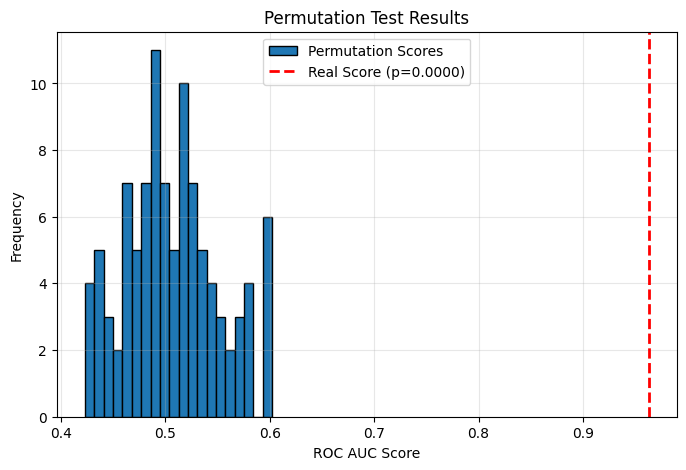

In [8]:
# Corrected_Analysis.ipynb

import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

from skimage import feature
from skimage.feature import graycomatrix, graycoprops

from sklearn.model_selection import GroupShuffleSplit, cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, confusion_matrix
from sklearn.base import clone

# --- Configuration ---
IMAGES_DIR = "all-mias"
META_PATH = "data2.txt"
IMAGE_SIZE = 1024
TARGET_ROI_SIZE = 256
RANDOM_STATE = 42

# --- 1. Data Loading and Preprocessing ---

def load_and_prepare_data(images_dir, meta_path):
    """Loads metadata, finds images, and extracts consistent ROIs for all samples."""
    col_names = ['REFNUM', 'BG', 'CLASS', 'SEVERITY', 'X', 'Y', 'RADIUS']
    df = pd.read_csv(meta_path, sep="\\s+", names=col_names, header=None)
    df['CANCER'] = df['SEVERITY'].apply(lambda x: 1 if x in ['B', 'M'] else 0)

    # Calculate median radius from abnormal cases to use for normal cases
    radii = pd.to_numeric(df[df['CANCER'] == 1]['RADIUS'], errors='coerce').dropna()
    median_radius = int(radii.median())

    all_rois = []
    all_labels = []
    all_groups = []

    for filename in sorted(os.listdir(images_dir)):
        if not filename.lower().endswith('.pgm'):
            continue
        
        ref_num = os.path.splitext(filename)[0]
        record = df[df['REFNUM'] == ref_num]
        if record.empty:
            continue

        record = record.iloc[0]
        full_path = os.path.join(images_dir, filename)
        img_array = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
        
        label = record['CANCER']
        patient_id = int(''.join(c for c in ref_num if c.isdigit())) // 2
        
        # Consistent ROI Extraction
        x, y, r = record[['X', 'Y', 'RADIUS']]
        
        if label == 1 and all(pd.notna([x, y, r])):
            cx, cy, cr = int(x), int(IMAGE_SIZE - float(y)), int(r)
        else:
            # For normal cases, take a crop from the center
            cx, cy, cr = IMAGE_SIZE // 2, IMAGE_SIZE // 2, median_radius
            
        # Crop a square ROI and apply CLAHE
        x0, y0 = max(0, cx - cr), max(0, cy - cr)
        x1, y1 = min(IMAGE_SIZE, cx + cr), min(IMAGE_SIZE, cy + cr)
        roi = img_array[y0:y1, x0:x1]

        if roi.size == 0:
            continue
        
        # Apply CLAHE to the ROI
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        roi_enhanced = clahe.apply(roi)
        
        # Resize to a fixed size for consistency
        roi_resized = cv2.resize(roi_enhanced, (TARGET_ROI_SIZE, TARGET_ROI_SIZE), interpolation=cv2.INTER_AREA)
        
        all_rois.append(roi_resized)
        all_labels.append(label)
        all_groups.append(patient_id)
        
    print(f"Successfully loaded and processed {len(all_rois)} images.")
    print(f"Label distribution: {Counter(all_labels)}")
    return np.array(all_rois), np.array(all_labels), np.array(all_groups)

# --- 2. Feature Extraction ---

def extract_glcm_features(patch, distances=[1, 3, 5], angles=[0, np.pi/4, np.pi/2, 3*np.pi/4]):
    """Computes GLCM features for a single patch."""
    glcm = graycomatrix(patch, distances=distances, angles=angles, levels=256, symmetric=True, normed=True)
    props = ['contrast', 'dissimilarity', 'homogeneity', 'ASM', 'energy', 'correlation']
    feats = {}
    for prop in props:
        mat = graycoprops(glcm, prop)
        feats[f'{prop}_mean'] = mat.mean()
        feats[f'{prop}_var'] = mat.var()
    return feats

def extract_lbp_features(patch, P=8, R=3, G=6):
    """Computes pooled LBP histogram features."""
    lbp = feature.local_binary_pattern(patch, P, R, method='uniform')
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))
    return hist

def create_feature_matrix(rois, labels, groups):
    """Loops over all ROIs to build the final feature matrix."""
    records = []
    for roi, label, grp in zip(rois, labels, groups):
        # GLCM
        glcm_feats = extract_glcm_features(roi)
        # LBP
        lbp_feats_hist = extract_lbp_features(roi)
        lbp_feats = {f'lbp_{i}': val for i, val in enumerate(lbp_feats_hist)}
        
        # Combine features and metadata
        all_feats = {**glcm_feats, **lbp_feats}
        all_feats['label'] = label
        all_feats['group'] = grp
        records.append(all_feats)
        
    df = pd.DataFrame.from_records(records)
    return df

# --- 3. Model Training and Evaluation ---

# Run the pipeline
rois, labels, groups = load_and_prepare_data(IMAGES_DIR, META_PATH)
feature_df = create_feature_matrix(rois, labels, groups)

X = feature_df.drop(columns=['label', 'group']).values
y = feature_df['label'].values

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Group-aware train/test split to prevent data leakage
gss = GroupShuffleSplit(n_splits=1, test_size=0.25, random_state=RANDOM_STATE)
train_idx, test_idx = next(gss.split(X_scaled, y, groups))

X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
y_train, y_test = y[train_idx], y[test_idx]

# --- Model Training ---
clf = RandomForestClassifier(n_estimators=300, random_state=RANDOM_STATE, class_weight='balanced')
clf.fit(X_train, y_train)

# --- Evaluation ---
y_pred = clf.predict(X_test)
y_prob = clf.predict_proba(X_test)[:, 1]

print("\n--- Model Evaluation on Held-Out Test Set ---")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# --- 4. Permutation Test ---
print("\n--- Running Permutation Test (100 permutations) ---")
cv = GroupShuffleSplit(n_splits=5, test_size=0.25, random_state=RANDOM_STATE)
score_real, _, _ = roc_auc_score(y_test, y_prob), None, None # Using held-out score as the real score

n_permutations = 100
perm_scores = []
for i in range(n_permutations):
    y_permuted = np.random.permutation(y)
    # Using a simple CV for the permutation test for speed
    perm_clf = clone(clf)
    score = cross_val_score(perm_clf, X_scaled, y_permuted, cv=cv, groups=groups, scoring='roc_auc').mean()
    perm_scores.append(score)
    print(f"Permutation {i+1}/{n_permutations}, Score: {score:.4f}", end='\\r')

p_value = (np.sum(np.array(perm_scores) >= score_real)) / n_permutations
print(f"\\nReal Model ROC AUC: {score_real:.4f}")
print(f"Permutation Scores Mean: {np.mean(perm_scores):.4f}")
print(f"P-value: {p_value:.4f}")
if p_value < 0.05:
    print("Result is statistically significant.")
else:
    print("Result is not statistically significant.")

# Plot permutation scores
plt.figure(figsize=(8, 5))
plt.hist(perm_scores, bins=20, label='Permutation Scores', edgecolor='k')
plt.axvline(score_real, color='red', linestyle='--', linewidth=2, label=f'Real Score (p={p_value:.4f})')
plt.title("Permutation Test Results")
plt.xlabel("ROC AUC Score")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [5]:
#
# Improved_LBP_GLCM_Pipeline.ipynb
#
# This script improves upon the robust structure of Method2 by adding
# data augmentation, a more powerful XGBoost classifier, and a more
# comprehensive hyperparameter search to maximize performance with LBP/GLCM features.
#

import os
import cv2
import numpy as np
import pandas as pd
from collections import Counter

# Scikit-learn and XGBoost imports
from skimage import feature
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold, GroupShuffleSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
from xgboost import XGBClassifier
from skimage.feature import graycomatrix, graycoprops

# --- Configuration ---
IMAGES_DIR = "all-mias"
META_PATH = "data2.txt"
IMAGE_SIZE = 1024
TARGET_ROI_SIZE = 128
RANDOM_STATE = 42

# CV and Split Configuration
HOLDOUT_TEST_SIZE = 0.2
INNER_CV_SPLITS = 4 # K-fold for grid search

# --- 1. Data Loading and Preprocessing with Augmentation ---

def load_and_prepare_data(images_dir, meta_path, augment_train=True):
    """Loads metadata and extracts ROIs. Includes an option for horizontal flip augmentation."""
    col_names = ['REFNUM', 'BG', 'CLASS', 'SEVERITY', 'X', 'Y', 'RADIUS']
    df = pd.read_csv(meta_path, sep="\\s+", names=col_names, header=None)
    df['CANCER'] = df['SEVERITY'].apply(lambda x: 1 if x in ['B', 'M'] else 0)
    radii = pd.to_numeric(df[df['CANCER'] == 1]['RADIUS'], errors='coerce').dropna()
    median_radius = int(radii.median())

    data = [] # Store tuples of (roi, label, group, is_augmented)

    print("Loading and preprocessing images...")
    for filename in sorted(os.listdir(images_dir)):
        if not filename.lower().endswith('.pgm'):
            continue
        
        ref_num = os.path.splitext(filename)[0]
        record = df[df['REFNUM'] == ref_num]
        if record.empty: continue

        record = record.iloc[0]
        full_path = os.path.join(images_dir, filename)
        img_array = cv2.imread(full_path, cv2.IMREAD_GRAYSCALE)
        
        label = record['CANCER']
        patient_id = int(''.join(c for c in ref_num if c.isdigit())) // 2 if ref_num[3:].isdigit() else ref_num

        x, y, r = record[['X', 'Y', 'RADIUS']]
        if label == 1 and all(pd.notna([x, y, r])):
            cx, cy, cr = int(x), int(IMAGE_SIZE - float(y)), int(r)
        else:
            cx, cy, cr = IMAGE_SIZE // 2, IMAGE_SIZE // 2, median_radius
            
        x0, y0 = max(0, cx - cr), max(0, cy - cr)
        x1, y1 = min(IMAGE_SIZE, cx + cr), min(IMAGE_SIZE, cy + cr)
        roi = img_array[y0:y1, x0:x1]

        if roi.size == 0: continue
        
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        roi_enhanced = clahe.apply(roi)
        roi_resized = cv2.resize(roi_enhanced, (TARGET_ROI_SIZE, TARGET_ROI_SIZE), interpolation=cv2.INTER_AREA)
        
        data.append({'roi': roi_resized, 'label': label, 'group': patient_id, 'is_augmented': False})

        # *** IMPROVEMENT: DATA AUGMENTATION ***
        # Add a horizontally flipped version of the ROI
        if augment_train:
            roi_flipped = cv2.flip(roi_resized, 1)
            data.append({'roi': roi_flipped, 'label': label, 'group': patient_id, 'is_augmented': True})

    print(f"Loaded {len(data)} images (including augmented).")
    return pd.DataFrame(data)

# --- 2. Feature Extraction (LBP + GLCM) ---

# CORRECTED FUNCTION

def extract_features(roi):
    """Extracts a combined feature vector of LBP and GLCM for a single ROI."""
    # LBP Features
    P, R, G = 8, 3, 3 # Points, Radius, Grid size
    lbp = feature.local_binary_pattern(roi, P, R, method='uniform')
    
    # --- FIX ---
    # Use a fixed number of bins for uniform LBP (P + 2)
    n_bins = P + 2 
    # --- END FIX ---
    
    # Pooled histogram
    H, W = lbp.shape
    h_step, w_step = H // G, W // G
    lbp_hist = []
    for i in range(G):
        for j in range(G):
            region = lbp[i*h_step:(i+1)*h_step, j*w_step:(j+1)*w_step]
            # Use fixed n_bins and range
            hist, _ = np.histogram(region.ravel(), bins=n_bins, range=(0, n_bins))
            lbp_hist.extend(hist)
    lbp_features = np.array(lbp_hist, dtype=float)

    # GLCM Features
    glcm = graycomatrix(roi, distances=[1, 3], angles=[0, np.pi/4, np.pi/2], levels=256, symmetric=True, normed=True)
    props = ['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'ASM']
    glcm_features = []
    for prop in props:
        glcm_features.extend(graycoprops(glcm, prop).ravel())
        
    # Combine and return
    return np.concatenate([lbp_features, glcm_features])
# --- 3. Model Training and Evaluation Pipeline ---

# Step 1: Load data
full_dataset = load_and_prepare_data(IMAGES_DIR, META_PATH, augment_train=True)

# Step 2: Group-aware train/test split (BEFORE feature extraction and augmentation handling)
# We split based on original images to ensure augmented versions stay with their originals.
original_indices = full_dataset[full_dataset['is_augmented'] == False].index
gss = GroupShuffleSplit(n_splits=1, test_size=HOLDOUT_TEST_SIZE, random_state=RANDOM_STATE)
train_idx_orig, test_idx_orig = next(gss.split(original_indices, groups=full_dataset.loc[original_indices, 'group']))

# Get the full training set (originals + their augmented pairs)
train_groups = full_dataset.loc[original_indices[train_idx_orig], 'group'].unique()
train_df = full_dataset[full_dataset['group'].isin(train_groups)]

# The test set contains ONLY original, non-augmented images
test_df = full_dataset.loc[original_indices[test_idx_orig]]

print(f"Training set size: {len(train_df)} (after augmentation)")
print(f"Test set size: {len(test_df)} (original images only)")

# Step 3: Extract features for train and test sets
print("\nExtracting features for training and test sets...")
X_train = np.array([extract_features(roi) for roi in train_df['roi']])
y_train = train_df['label'].values
groups_train = train_df['group'].values

X_test = np.array([extract_features(roi) for roi in test_df['roi']])
y_test = test_df['label'].values

# Step 4: Define pipelines and hyperparameter grids
scaler = StandardScaler()
selector = SelectKBest(mutual_info_classif)

# Pipeline definitions
rf_pipeline = Pipeline([('scaler', scaler), ('select', selector), ('clf', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced'))])
svm_pipeline = Pipeline([('scaler', scaler), ('select', selector), ('clf', SVC(probability=True, random_state=RANDOM_STATE, class_weight='balanced'))])
xgb_pipeline = Pipeline([('scaler', scaler), ('select', selector), ('clf', XGBClassifier(random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss'))])


# *** IMPROVEMENT: Expanded Hyperparameter Grids ***
rf_params = {
    'select__k': [40, 80, 120],
    'clf__n_estimators': [100, 250, 500],
    'clf__max_depth': [5, 10, 20, None],
    'clf__min_samples_leaf': [1, 3, 5]
}

svm_params = {
    'select__k': [40, 80, 120],
    'clf__C': [0.1, 1, 10, 100],
    'clf__gamma': ['scale', 0.01, 0.001]
}

xgb_params = {
    'select__k': [40, 80, 120],
    'clf__n_estimators': [100, 250, 500],
    'clf__max_depth': [3, 5, 7],
    'clf__learning_rate': [0.01, 0.1, 0.2]
}

pipelines = {
    'RandomForest': (rf_pipeline, rf_params),
    'SVM': (svm_pipeline, svm_params),
    'XGBoost': (xgb_pipeline, xgb_params) # *** IMPROVEMENT: Added XGBoost ***
}

# Step 5: Run GridSearchCV for each model
print("\n--- Starting Hyperparameter Tuning ---")
best_estimators = {}
inner_cv = GroupKFold(n_splits=INNER_CV_SPLITS)

for name, (pipeline, params) in pipelines.items():
    print(f"\nTuning {name}...")
    gs = GridSearchCV(pipeline, params, cv=inner_cv.split(X_train, y_train, groups_train), scoring='roc_auc', n_jobs=-1, verbose=1)
    gs.fit(X_train, y_train)
    best_estimators[name] = gs.best_estimator_
    print(f"Best Score (AUC) for {name}: {gs.best_score_:.4f}")
    print(f"Best Params for {name}: {gs.best_params_}")

# Step 6: Evaluate the best models on the held-out test set
print("\n--- Final Model Evaluation on Held-Out Test Set ---")
for name, model in best_estimators.items():
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    print(f"\n--- Results for Best {name} ---")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"ROC AUC Score: {roc_auc_score(y_test, y_prob):.4f}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=["Normal", "Cancer"]))
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

Loading and preprocessing images...
Loaded 648 images (including augmented).
Training set size: 516 (after augmentation)
Test set size: 66 (original images only)

Extracting features for training and test sets...

--- Starting Hyperparameter Tuning ---

Tuning RandomForest...
Fitting 4 folds for each of 108 candidates, totalling 432 fits
Best Score (AUC) for RandomForest: 0.9199
Best Params for RandomForest: {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__n_estimators': 500, 'select__k': 40}

Tuning SVM...
Fitting 4 folds for each of 36 candidates, totalling 144 fits
Best Score (AUC) for SVM: 0.9140
Best Params for SVM: {'clf__C': 100, 'clf__gamma': 0.001, 'select__k': 40}

Tuning XGBoost...
Fitting 4 folds for each of 81 candidates, totalling 324 fits
Best Score (AUC) for XGBoost: 0.9312
Best Params for XGBoost: {'clf__learning_rate': 0.1, 'clf__max_depth': 7, 'clf__n_estimators': 100, 'select__k': 40}

--- Final Model Evaluation on Held-Out Test Set ---

--- Results for Best

C:\Users\aa23147\AppData\Roaming\Python\Python312\site-packages\xgboost\training.py:183: UserWarning: [20:56:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [1]:
# Standard & third-party libraries
import os
import cv2
import json
import math
import time
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from scipy.stats import skew
from skimage.feature import local_binary_pattern, graycomatrix, graycoprops
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.model_selection import GroupKFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score, recall_score, confusion_matrix, classification_report, roc_auc_score
)


In [2]:
def read_metadata(meta_path):
    meta = pd.read_csv(meta_path, delim_whitespace=True, dtype=str)
    meta.columns = [c.strip().upper() for c in meta.columns]
    if 'SEVERITY' in meta.columns:
        meta['CANCER'] = meta['SEVERITY'].map({'B': 1, 'M': 1}).fillna(0).astype(int)
    elif 'CLASS' in meta.columns:
        meta['CANCER'] = meta['CLASS'].map({'B': 1, 'M': 1}).fillna(0).astype(int)
    else:
        raise ValueError("Missing CLASS or SEVERITY column for cancer label.")
    meta['RADIUS'] = pd.to_numeric(meta['RADIUS'], errors='coerce')
    meta['X'] = pd.to_numeric(meta['X'], errors='coerce')
    meta['Y'] = pd.to_numeric(meta['Y'], errors='coerce')
    meta['patient_id'] = meta['REFNUM'].str.extract(r'([a-zA-Z]+)')[0]
    return meta


def preprocess_img(img, target_size=1024, min_side=32):
    h, w = img.shape
    if min(h, w) < min_side:
        return None
    scale = target_size / min(h, w)
    new_h, new_w = int(h * scale), int(w * scale)
    img_resized = cv2.resize(img, (new_w, new_h), interpolation=cv2.INTER_AREA)
    return img_resized


def roi_from_row(img, row, fallback_radius=32, target_size=64):
    x, y = row['X'], row['Y']
    radius = row['RADIUS']
    if pd.isna(radius):
        radius = fallback_radius
    r = int(radius)
    x, y = int(x), int(y)
    roi = img[max(0, y - r): y + r, max(0, x - r): x + r]
    roi_resized = cv2.resize(roi, (target_size, target_size), interpolation=cv2.INTER_AREA)
    return roi_resized


In [3]:
def compute_glcm_features(roi, levels=32, distances=[1], angles=[0]):
    roi_scaled = (roi / (256 / levels)).astype(np.uint8)
    glcm = graycomatrix(roi_scaled, distances=distances, angles=angles, levels=levels, symmetric=True, normed=True)
    feats = {
        'contrast': graycoprops(glcm, 'contrast').mean(),
        'dissimilarity': graycoprops(glcm, 'dissimilarity').mean(),
        'homogeneity': graycoprops(glcm, 'homogeneity').mean(),
        'energy': graycoprops(glcm, 'energy').mean(),
        'correlation': graycoprops(glcm, 'correlation').mean(),
        'ASM': graycoprops(glcm, 'ASM').mean(),
    }
    return feats


def compute_lbp_hist(roi, P=8, R=1, bins=59):
    lbp = local_binary_pattern(roi, P, R, method='uniform')
    hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, bins + 1), range=(0, bins))
    hist = hist.astype(float)
    hist /= (hist.sum() + 1e-6)
    return {f'lbp_{i}': h for i, h in enumerate(hist)}


def intensity_stats(roi):
    return {
        'mean': np.mean(roi),
        'std': np.std(roi),
        'skew': skew(roi.flatten())
    }


def convert(feat_dicts):
    all_keys = sorted({k for d in feat_dicts for k in d})
    X = np.array([[d.get(k, 0) for k in all_keys] for d in feat_dicts])
    return X, all_keys


In [4]:
def evaluate_model(name, y_true, y_pred, y_prob):
    acc = accuracy_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    cm = confusion_matrix(y_true, y_pred)
    print(f"=== Held-out evaluation: {name} ===")
    print(f"Accuracy: {acc:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"AUC: {auc:.4f}")
    print("Confusion Matrix:\n", cm)
    print(classification_report(y_true, y_pred))
